# Before begins

This notebook is written in google colab.

To see some interactive plots, please enter the colab link Below.

<a href="https://colab.research.google.com/drive/1WPxPqsUsWxgZcmeHRsXn-jYR6aJLdegO?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Overview

<br>

## Competition description

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/4699/logos/thumb76_76.png" width=40 align='left' alt="Open in Colab"/></a>
&nbsp; 
<font size="5">[Prudential Life Insurance Assessment](https://www.kaggle.com/c/titanic)</font>

- Problem type: (Ordinal) classification
  - Predicting the risk (8 classes) of individual in terms of life insurance
- Evaluation metric: [quadratic weighted kappa](https://www.kaggle.com/c/prudential-life-insurance-assessment/overview/evaluation)

<br>

## Notebook description

This notebook provides the '**proper workflow**' for kaggle submission.

The workflow is divided into three main steps.
1. Data preprocessing
2. Model selection (hyper parameter tuning, model combination, model comparison)
3. Training final model & Prediction on Test-set

At each stage, detailed descriptions of the work and an appropriate procedure will be provided.

Through this notebook, readers can learn the 'proper workflow' to be done for kaggle submission, 
and using this as a basic structure, someone will be able to apply this to other competitions easily with some adjustments

**Warnings**:
- The purpose of this notebook
  - This notebook focuses on the 'procedure' rather than the 'result'. 
  - Thus this notebook does not guide you on how to achieve the top score. Since I personally think that any result can only have a meaning through an appropriate procedure.
  - But since this is a competition, it cannot be avoided that the score is important. Following this notebook, you will get the top 15% (score: 0.12519) result in this competition

- The readers this notebook is intended for
  - Who are aware of the basic usage of data processing tools (e.g., numpy, pandas)
  - Who are aware of the basic concepts of machine learning models 


# 0. Configuration

Set the configurations for this notebook

In [1]:
config = {
    'data_name': 'Prudential_Risk',
    'random_state': 2022
}

# 1. Data preprocessing

The data preprocessing works are divided into 8 steps here.

Some of these steps are mandatory and some are optional.

Optional steps are marked separately.

It is important to go through each step in order.
Be careful not to reverse the order.

## 1-1. Load Dataset

Load train-set and test-set on working environment

Please download the data from [(Kaggle) Prudential](hhttps://www.kaggle.com/c/prudential-life-insurance-assessment/data) and upload on your google drive in the path 'content/drive/MyDrive/Work/Kaggle/Prudential_Risk/Data'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/{}/Data/train.csv'.format(config['data_name']))
test = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/{}/Data/test.csv'.format(config['data_name']))

> ### Concatenate the 'train' and 'test' data for preprocessing

Data preprocessing work should be applied equally for train-set and test-set.

In order to work at once, exclude the response variable 'Response' from 'train' and combine it with 'test'.

In [4]:
all_features = pd.concat((train.drop(['Id','Response'], axis=1), test.drop(['Id'], axis=1)), axis=0)

## 1-2. Missing Value Treatment

Missing (NA) values in Data must be treated properly before model training.

There are three main treatment methods:
1. Remove the variables which have NA values
2. Remove the rows (observations) which have NA values
3. Impute the NA values with other values

Which of the above methods is chosen is at the analyst's discretion.
It is important to choose the appropriate method for the situation.

### > Check missing values in each variable


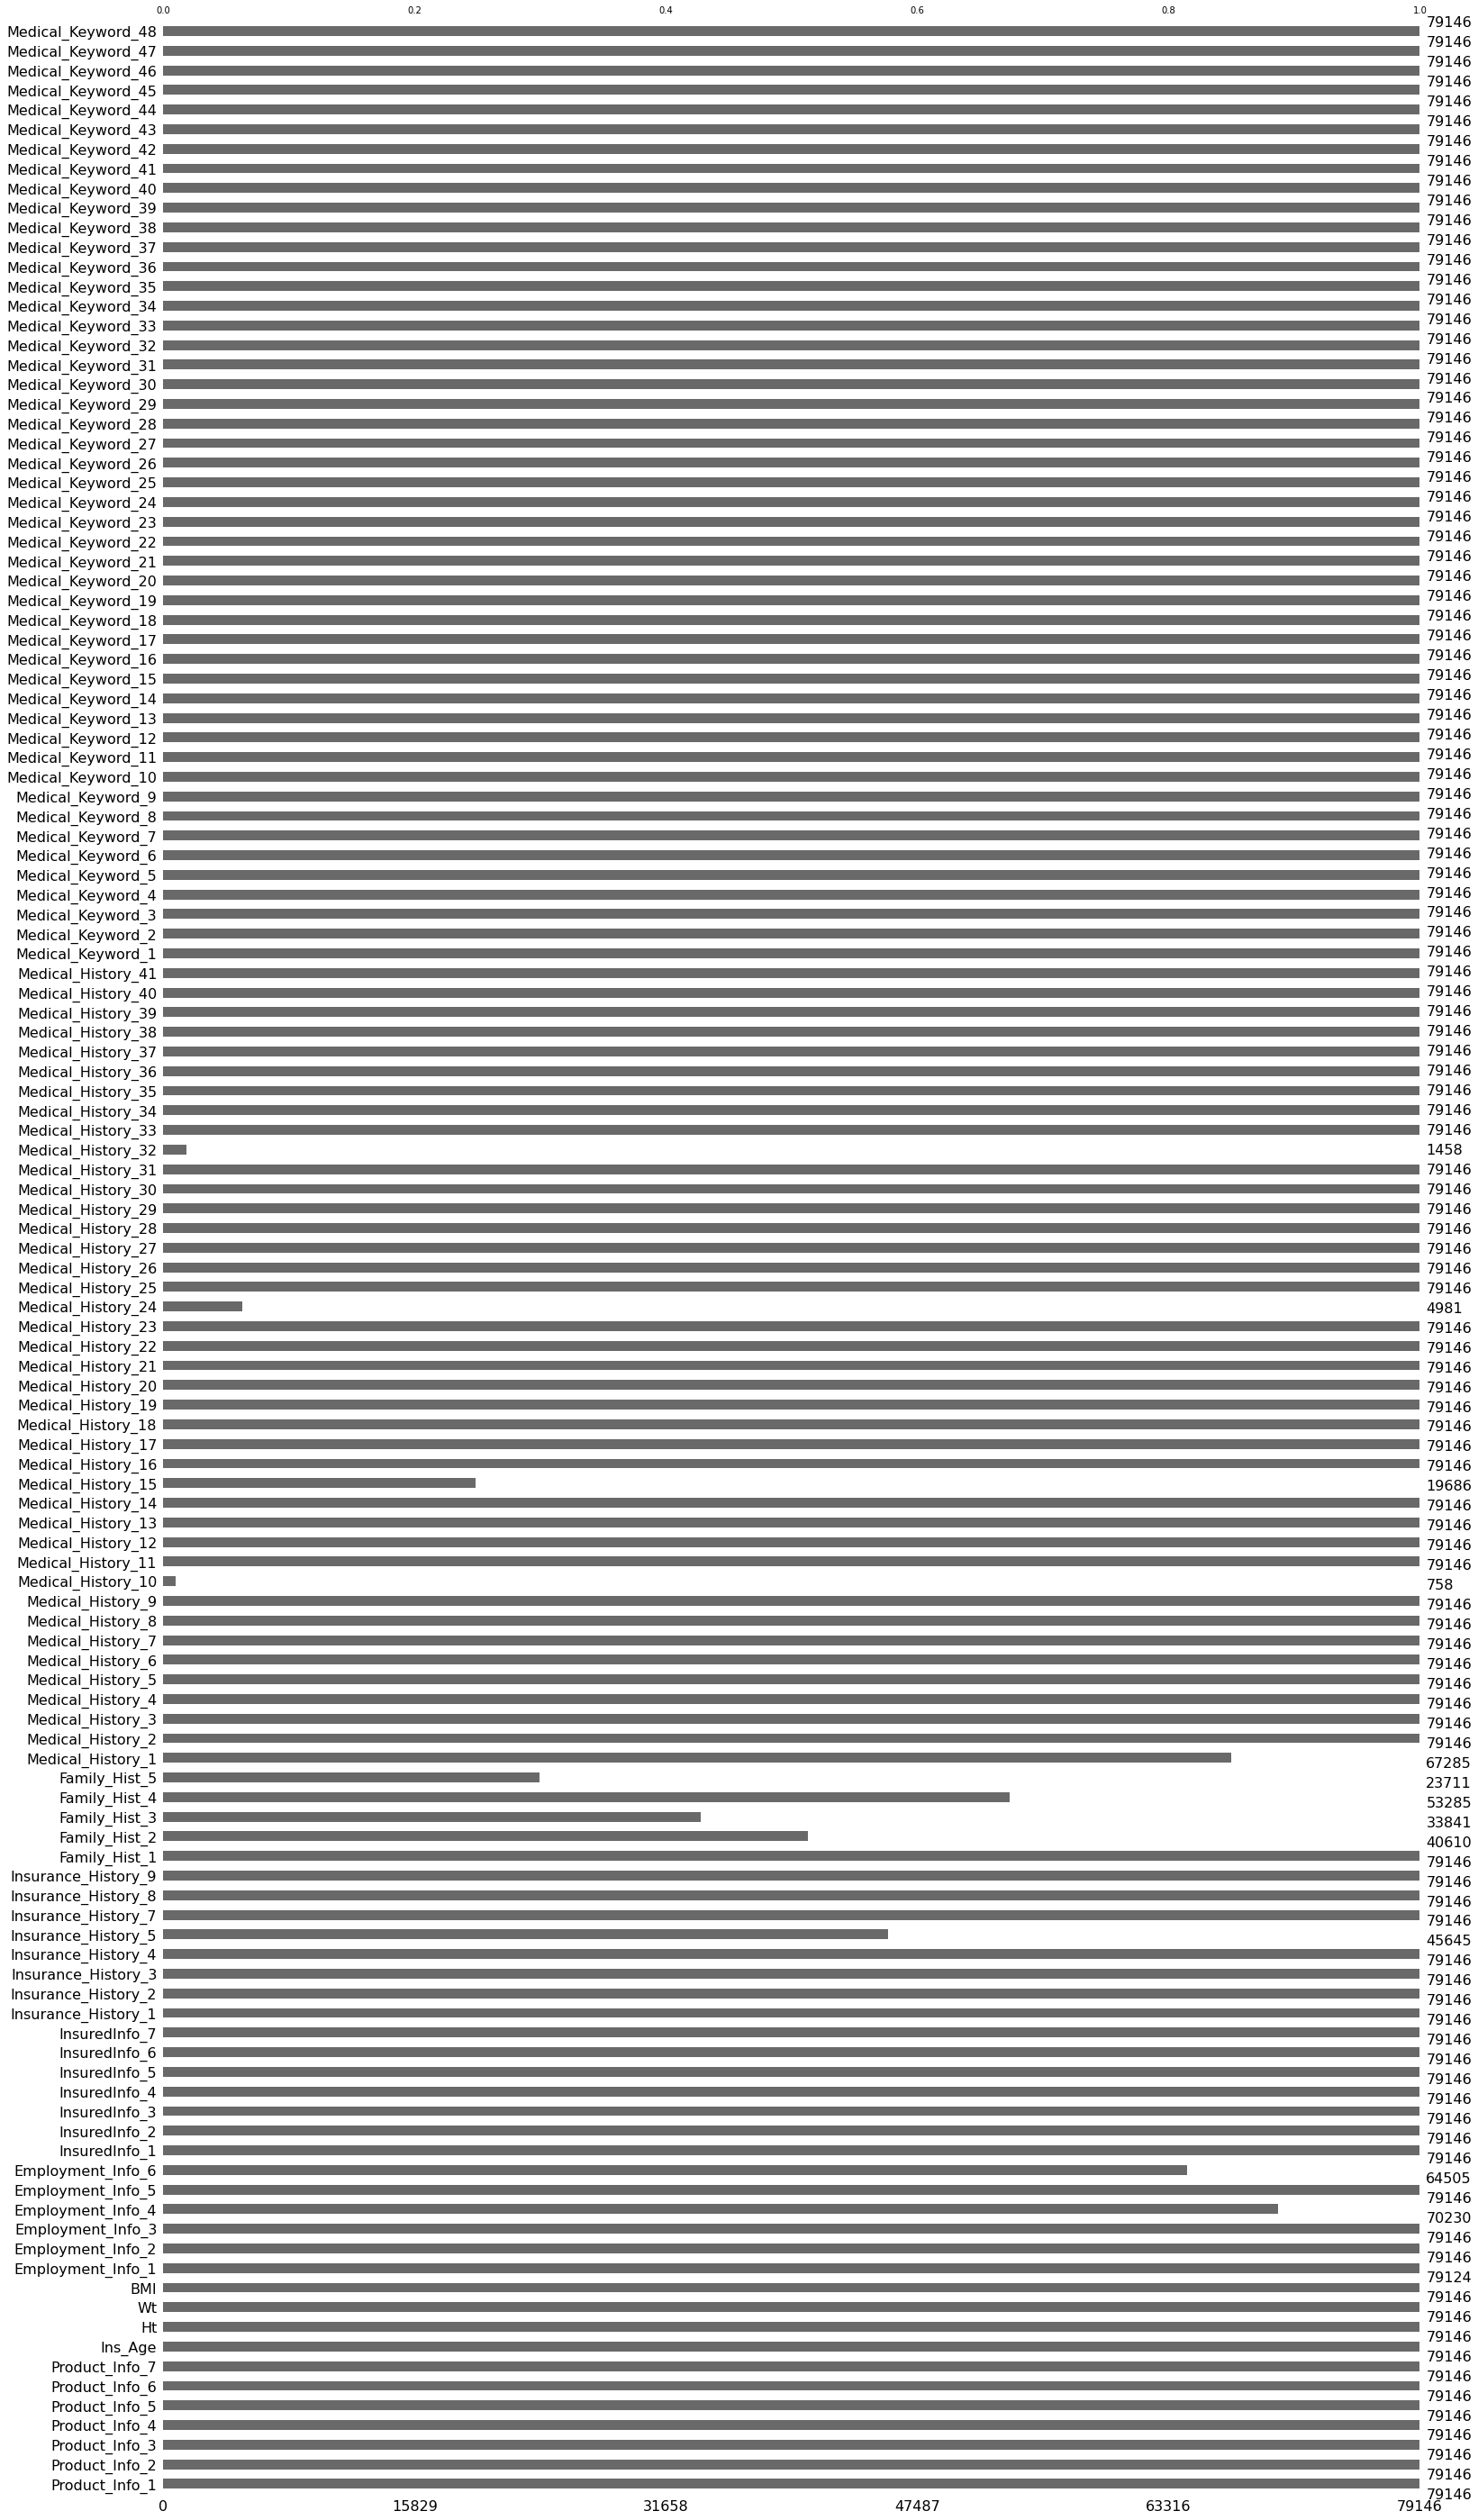

In [5]:
import missingno as msno
msno.bar(all_features)

### > Remove highly proportioned nan variables (nan proportion > 30%)

In [6]:
condition_col_idx = ((all_features.isnull().sum() / all_features.shape[0]) > 0.3).values

print(all_features.iloc[:,condition_col_idx].isnull().sum()/ all_features.shape[0])

all_features = all_features.iloc[:, ~condition_col_idx]

Insurance_History_5    0.423281
Family_Hist_2          0.486898
Family_Hist_3          0.572423
Family_Hist_4          0.326751
Family_Hist_5          0.700414
Medical_History_10     0.990423
Medical_History_15     0.751270
Medical_History_24     0.937066
Medical_History_32     0.981578
dtype: float64


### > Impute the NA values properly

There are 4 variables that have NA values left.

And these are all numeric (interger, float) variables

In [7]:
all_features.iloc[:,all_features.isnull().any().values].head()

,Employment_Info_1,Employment_Info_4,Employment_Info_6,Medical_History_1
0,0.028,0.0,NaN,4.0
1,0.000,0.0,0.0018,5.0
2,0.030,0.0,0.0300,10.0
3,0.042,0.0,0.2000,0.0
4,0.027,0.0,0.0500,NaN


#### >> Replace NA by 'median value' of the variable grouped by another (relevant) categorical variable


The figures below show that the distribution of y-axis variable is different depending on the x-axis variable values.

(ANOVA test is used to determine whether the differences between groups are significant.)


In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

by_var_list = ['Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5']
target_list = ['Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6']

anova_res_list = []
for target in target_list:
  for by_var in by_var_list:
    formula = target + '~' + by_var
    model = ols(formula, data=all_features).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_res_list.append([target, by_var, anova_table['F'][0]])

anova_res = pd.DataFrame(np.vstack((anova_res_list)), columns=['target', 'by_var', 'F-statistic'])    
anova_res['F-statistic'] = anova_res['F-statistic'].astype(np.float32)

import plotly.express as px
fig = px.bar(anova_res, x='target', y='F-statistic', color='by_var', width=800, height=400, barmode='group')
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

by_var_list = all_features.iloc[:,all_features.columns.str.startswith('Medical')].select_dtypes(exclude=np.float64).columns
target_list = ['Medical_History_1']

anova_res_list = []
for target in target_list:
  for by_var in by_var_list:
    formula = target + '~' + by_var
    model = ols(formula, data=all_features).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_res_list.append([target, by_var, anova_table['F'][0]])

anova_res = pd.DataFrame(np.vstack((anova_res_list)), columns=['target', 'by_var', 'F-statistic'])    
anova_res['F-statistic'] = anova_res['F-statistic'].astype(np.float32)

import plotly.express as px
fig = px.bar(anova_res, x='target', y='F-statistic', color='by_var', width=800, height=400, barmode='group')
fig.show()

In [10]:
method = 'median'

all_features.loc[:,'Employment_Info_1'] = all_features.loc[:,'Employment_Info_3'].fillna(all_features.groupby('Employment_Info_3')['Employment_Info_1'].transform(method))
all_features.loc[:,'Employment_Info_4'] = all_features.loc[:,'Employment_Info_3'].fillna(all_features.groupby('Employment_Info_5')['Employment_Info_4'].transform(method))
all_features.loc[:,'Employment_Info_6'] = all_features.loc[:,'Employment_Info_3'].fillna(all_features.groupby('Employment_Info_3')['Employment_Info_6'].transform(method))

all_features.loc[:,'Medical_History_1'] = all_features.loc[:,'Medical_History_23'].fillna(all_features.groupby('Medical_History_23')['Medical_History_1'].transform(method))

In [11]:
assert not all_features.isnull().sum().any()

## 1-3. Categorical variable consideration

### > 'Medical_Keyword_[1-48]' variables

'Medical_Keyword_[1-48]' variables have only {0, 1} values

In [12]:
var_idx = all_features.columns.str.startswith('Medical_Keyword')
np.unique(all_features.iloc[:,var_idx].values)

array([0, 1])

But sum of values through axis=1 has values > 1 
So, we can think that these variables are set of one-hot encoded (dummified) variables
NOT one-hot encoded on 'ONE' variable
Thus we must not remove any of them cause we do not know which variables are orginaliy same variable

In [13]:
all_features.iloc[:,var_idx].sum(axis=1).value_counts()

0     31247
1     21430
2     12573
3      7046
4      3652
5      1793
6       796
7       374
8       132
9        67
10       24
11        5
12        3
16        2
14        1
13        1
dtype: int64

In [14]:
var_idx = all_features.columns.str.startswith('Medical_Keyword')
all_features.iloc[:,var_idx] = all_features.iloc[:,var_idx].astype(np.uint8)

## 1-4. Dummify categorical variables

In the case of linear modeling without regularization, the first or last column should be dropped (to prevent linear dependency), but here, for the convenience of using the factorization model, one-hot encoding method is used that does not drop any columns.

In [15]:
data_set = pd.get_dummies(all_features, drop_first=False)

## 1-5. Scaling continuous variables

The float variables 'Age' and 'Fare' were measured in different units.
MinMaxScaling maps all variables from 0 to 1 in order to consider only relative information, not absolute magnitudes of values.

Besides, it is known that scaling is often more stable in parameter optimization when training a model.

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_set = scaler.fit_transform(data_set)

## 1-6. Split Train & Test set

In [17]:
n_train = train.shape[0]
X_train = data_set[:n_train].astype(np.float32)
X_test = data_set[n_train:].astype(np.float32)
y_train = train['Response'].values.astype(np.int64)

## 1-7. Outlier Detection on Training data (*optional*)

Detect and remove outlier observations that exist in the train-set.

- Methodology: [Isolation Forest](https://ieeexplore.ieee.org/abstract/document/4781136/?casa_token=V7U3M1UIykoAAAAA:kww9pojtMeJtXaBcNmw0eVlJaXEGGICi1ogmeHUFMpgJ2h_XCbSd2yBU5mRgd7zEJrXZ01z2)
  - How it works
    - Isolation Forest applies a decision tree that repeats splits based on the 'random criterion' for the given data unitl only one observation remains in every terminal node (this is defined as 'isolation').
    - Based on the number of splits used for isolation, 'normality' is defined. A smaller value means a higher degree of outlierness.
    - By applying this decision tree several times, the average of the measured 'normality' values ​​is derived as the final 'normality' value.
  - Assumptions
    - Outliers require relatively few splits to be isolated.
    - For normal data, the number of splits required to be isolated is relatively large.
  - Outlier determination
    - Determines whether it is an outlier or not based on the measured 'normality' value.
      - sklearn's IsolationForest package determines based on '0' 
      - I, personally, think it is better to set the discriminant criterion by considering the 'distribution' of the 'normality' values.
      - The details of the method is given below.

In [18]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    n_jobs=-1,
    random_state=config['random_state'])

clf.fit(X_train)
normality_df = pd.DataFrame(clf.decision_function(X_train), columns=['normality'])

The discriminant value (threshold) is defined by calculating the 1st quartile ($q_1$) and 3rd quartile ($q_3$) on the distribution of the measured normality values.

$threshold = q_1 - k*(q_3 - q_1)$

- In this case, set $k=1.5$.

This discriminant method is adapted from Tukey's boxplot idea.
In the distribution of any continuous variable, Tukey designates observations smaller than that value or larger than q_3 + k*(q_3 - q_1) as outliers.

Our methodology does not apply the above method to a specific variable, but applies the method to the obtained normality.

That is, it is based on the assumption that an outlier will be far left from the other observations in the measured normality distribution.

In [19]:
def outlier_threshold(normality, k=1.5):
  q1 = np.quantile(normality, 0.25)
  q3 = np.quantile(normality, 0.75)  
  threshold = q1 - k*(q3-q1)
  return threshold

threshold = outlier_threshold(normality_df['normality'].values, k=1.5)

import plotly.express as px
fig = px.histogram(normality_df, x='normality', width=400, height=400)
fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="red")
fig.show()

In [20]:
import plotly.express as px
px.box(normality_df, x='normality', orientation='h', width=400, height=400)

In [21]:
X_train = X_train[normality_df['normality'].values>=threshold]
y_train = y_train[normality_df['normality'].values>=threshold]

print('{} out of {} observations are removed from train_set'.format(train.shape[0] - X_train.shape[0], train.shape[0]))

1335 out of 59381 observations are removed from train_set


## 1-8. Output variable transformation

In [22]:
print('Before transformation:', np.unique(y_train))

y_train_trans = y_train - 1

print('After transformation:', np.unique(y_train_trans))

Before transformation: [1 2 3 4 5 6 7 8]
After transformation: [0 1 2 3 4 5 6 7]


In [206]:
# y_train_trans_list = []
# for i in range(len(np.unique(y_train_trans))-1):
#   thres = np.unique(y_train_trans)[i]
#   y_train_trans_list.append(y_train_trans > thres)

# y_train_trans_mat = np.vstack((y_train_trans_list)).transpose() + 0

## 1-9. Undersampling

In [24]:
# from imblearn.under_sampling import NearMiss 

# nm = NearMiss(version=1, n_neighbors=10, n_jobs=-1)
# X_train_res, y_train_trans_res = nm.fit_resample(X_train, y_train_trans)


# 2. Model Selection

Our goal is to build a model that predicts the forest cover type given the cartographic informations of the forest. The formula can be expressed as:

$\hat{y} = \underset{k \in \{1,\cdots,K\}}{\operatorname{argmax}}f_{k}(x)$

where,
  - $y \in \{1,\cdots,K\} $: labels 
  - $x$: an input observation
  - $f_{k}(x)$: a function of $x$ that outputs predicted value for each $k$

This is a typical multiclass classification problem, and various machine learning models can be obtained. This notebook uses the following models.
- Logistic regression
- Support vector machine
- Random forest
- Xgboost
- Multi-layer perceptron
- Factorization

However, we have to "choose" one final methodology to make predictions on the test set.
To do this, a “fair evaluation” of the models is essential. "Fair evaluation" must satisfy the following two conditions.

1. Select optimal hyperparameters for each model
  - If hyperparameter search is not performed, the difference in model performance may occur due to incorrect hyperparameter values.
2. same evaluation method
  - If the same evaluation method is not applied, comparison between models itself is impossible.

When comparing models through an evaluation method that satisfies the above two conditions,
Only then can the final model be selected.




### > Install Packages

In [31]:
!pip install tune_sklearn ray[tune] skorch

### > Define a scoring function for hyper parameter tuning


In [32]:
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

def pred_mat_to_vec(pred_proba_mat):
  unique_class = np.arange(len(pred_proba_mat)+1)
  each_predict = {k: pred_proba_mat[k] for k in range(len(pred_proba_mat))}
  preds = []
  for i, y in enumerate(unique_class):
      if i == 0:
          # V1 = 1 - Pr(y > V1)
          preds.append(1 - each_predict[i][:,1])
      elif i in each_predict:
          # Vi = Pr(y > Vi-1) - Pr(y > Vi)
            preds.append(each_predict[i-1][:,1] - each_predict[i][:,1])
      else:
          # Vk = Pr(y > Vk-1)
          preds.append(each_predict[i-1][:,1])
  pred_mat = np.vstack(preds).T
  pred_class = np.argmax(pred_mat, axis=1)
  return pred_class

def weighted_kappa_ordinal(y_true_mat, pred_proba_mat):
  y_true = y_true_mat.sum(1)
  y_pred = pred_mat_to_vec(pred_proba_mat)
  try:
    score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
  except:
    score = np.nan
  return score

target_metric_ordinal = make_scorer(weighted_kappa_ordinal, greater_is_better=True, needs_proba=True)

In [33]:
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

def weighted_kappa(y_true, y_pred):
  try:
    score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
  except:
    score = np.nan
  return score

target_metric = make_scorer(weighted_kappa, greater_is_better=True)

## 2-1. Hyper parameter tuning by using Tune_SKlearn (Ray Tune)

- Package: tune_sklearn
  - This package makes it easy to apply [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) to sklearn models.
  - Ray Tune is a python package that provides various hyperparameter tuning algorithms (HyperOpt, BayesianOptimization, ...).
- Tuning procedure
  - Define an appropriate search space for each model's hyperparameters.
  - 5-fold CV (Cross Validation) is performed for each specific hyper-parameter value combination of the search space by using the hyper-parameter tuning algorithm (HyperOpt)
    - Training: Training by using Scikit-Learn and Skorch packages
    - Validation: Evaluate the model using an appropriate evaluation metric
  - The hyperparameter with the highest average score of the CV result is designated as the optimal hyperparameter of the model.
    - Save this CV result and use for model comparison



> ### Make a dataframe for containing CV results

In [34]:
model_list = []
for name in ['linear', 'rf', 'xgb', 'mlp']:
  model_list.append(np.full(5, name))
  
best_cv_df = pd.DataFrame({'model': np.hstack((model_list)), 'accuracy':None, 'kappa':None, 'best_hyper_param': None})

In [126]:
from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.metrics import accuracy_score
class OrdinalClassifier(BaseEstimator):

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                try:
                  clf.module
                except: # For others
                  clf.fit(X, binary_y)
                else: # For MLP
                  binary_y_reshape = binary_y.astype('float32').reshape(-1,1)
                  clf.fit(X, binary_y_reshape)
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[i][:,1])
            elif i in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[i-1][:,1] - clfs_predict[i][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[i-1][:,1])
        try:
          self.clf.module
        except: # For others
          pred_proba = np.vstack(predicted).T      
        else: # For MLP
          pred_proba = np.hstack((predicted))
        
        return pred_proba

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y, sample_weight=None):
        _, indexed_y = np.unique(y, return_inverse=True)
        return accuracy_score(indexed_y, self.predict(X), sample_weight=sample_weight)

### Logistic regression

In [160]:
from tune_sklearn import TuneSearchCV
from sklearn.linear_model import SGDClassifier

parameters = {
    'clf__alpha': list(np.geomspace(1e-5, 1e-2, 4)),
    'clf__max_iter': [1000],
    'clf__tol': [1e-4, 1e-3, 1e-2],
    'clf__loss': ['log'],
    'clf__penalty': ['l2'],
    'clf__random_state': [config['random_state']],
}

clf = SGDClassifier()
ordinal_clf = OrdinalClassifier(clf)

tune_search = TuneSearchCV(
    ordinal_clf,
    parameters,
    search_optimization='hyperopt',
    n_trials=6,
    n_jobs=-1,
    scoring={'accuracy':'accuracy', 'kappa':target_metric},
    cv=5,
    refit='kappa',
    verbose=1,
    random_state=config['random_state']
    )

# Run hyper parameter tuning
X = X_train
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'linear'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'kappa'] = cv_values[5:]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_kappa')
fig.show()

### Random forest

In [64]:
from tune_sklearn import TuneSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'clf__n_estimators': [50, 100],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [20, 25, 30],
    'clf__max_features': ['auto'],
    'clf__random_state': [config['random_state']]
}

clf = RandomForestClassifier()
ordinal_clf = OrdinalClassifier(clf)

tune_search = TuneSearchCV(
    ordinal_clf,
    parameters,
    search_optimization='hyperopt',
    n_trials=4,
    n_jobs=-1,
    scoring={'accuracy':'accuracy', 'kappa':target_metric},
    cv=5,
    refit='kappa',
    verbose=1,
    random_state=config['random_state']
    )

# Run hyper parameter tuning
X = X_train
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'rf'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'kappa'] = cv_values[5:]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.get_dummies(pd.DataFrame(tune_search.cv_results_['params']), drop_first=False), 
                            cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
tune_result_df = tune_result_df.astype({'clf__criterion_entropy':'int64', 'clf__criterion_gini':'int64'})
import plotly.express as px
px.parallel_coordinates(tune_result_df, color='mean_test_kappa')

### XGBoost

In [59]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBClassifier

parameters = {
    'clf__n_estimators': [10, 50],
    'clf__learning_rate': list(np.geomspace(1e-2, 1, 3)),
    'clf__min_child_weight': [5, 10, 15],
    'clf__gamma': [0.5, 2],
    'clf__subsample': [0.6, 1.0],
    'clf__colsample_bytree': [0.6, 1.0],
    'clf__max_depth': [5, 10, 15],
    'clf__lambda': [1],
    'clf__objective': ['binary:logistic'],
    'clf__random_state': [config['random_state']]
}

clf = XGBClassifier()
ordinal_clf = OrdinalClassifier(clf)

tune_search = TuneSearchCV(
    ordinal_clf,
    parameters,
    search_optimization='hyperopt',
    n_trials=4,
    n_jobs=-1,
    scoring={'accuracy':'accuracy', 'kappa':target_metric},
    cv=5,
    refit='kappa',
    verbose=1,
    random_state=config['random_state']
    )

# Run hyper parameter tuning
X = X_train
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'xgb'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'kappa'] = cv_values[5:]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_kappa')
fig.show()

### Multi-layer perceptron

In [155]:
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring
from skorch.callbacks import Checkpoint
from tune_sklearn import TuneSearchCV


class MLP(nn.Module):
    def __init__(self, num_inputs=X_train.shape[1], num_outputs=1, layer1=512, layer2=256, dropout1=0, dropout2=0):
        super(MLP, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_inputs, layer1),
            nn.LeakyReLU(),
            nn.Dropout(dropout1),
            nn.Linear(layer1, layer2),
            nn.LeakyReLU(),
            nn.Dropout(dropout2),
            nn.Linear(layer2, num_outputs)
            )
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x  

def try_gpu(i=0): 
    return f'cuda:{i}' if torch.cuda.device_count() >= i + 1 else 'cpu'

mlp = NeuralNetClassifier(
    MLP(num_inputs=X_train.shape[1], num_outputs=1),
    criterion=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.Adam,
    device=try_gpu(),
    verbose=0,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=5,
                             threshold=1e-3, lower_is_better=False)]
                          )

clf = mlp
ordinal_clf = OrdinalClassifier(clf)

parameters = {
    'clf__lr': list(np.geomspace(1e-4, 1e-1, 4)),
    'clf__module__layer1': [128, 256, 512],
    'clf__module__layer2': [128, 256, 512],
    'clf__module__dropout1': [0, 0.1],
    'clf__module__dropout2': [0, 0.1],
    'clf__batch_size': [128, 256],
    'clf__optimizer__weight_decay': list(np.geomspace(1e-5, 1e-1, 5)),
    'clf__max_epochs': [2000],
    'clf__iterator_train__shuffle': [True],
    'clf__callbacks__EarlyStopping__threshold': [1e-4, 1e-3]
    }

def use_gpu(device):
    return True if not device == 'cpu' else False 

tune_search = TuneSearchCV(
    ordinal_clf,
    parameters,
    search_optimization='hyperopt',
    n_trials=10,
    n_jobs=-1,
    scoring={'accuracy':'accuracy', 'kappa':target_metric},
    cv=5,
    refit='kappa',
    verbose=1,
    random_state=config['random_state']
    )

# Run hyper parameter tuning
X = X_train
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'mlp'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'kappa'] = cv_values[5:]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
tune_result_df.rename({
    'clf__callbacks__EarlyStopping__threshold':'Earlystoping_threshold',
    'clf__optimizer__weight_decay': 'weight_decay'
    }, axis=1, inplace=True)
import plotly.express as px
px.parallel_coordinates(tune_result_df, color='mean_test_kappa')

> ### Save CV results

In [156]:
import os 
save_path = '/content/drive/MyDrive/Work/Kaggle/{}/Result'.format(config['data_name'])
if not os.path.exists(save_path):
  os.makedirs(save_path)
file_path = os.path.join(save_path, 'best_cv_results_ordinal.csv')
best_cv_df.to_csv(file_path, index=False)

## 2-2. Model Comparison based on CV results

Compare the CV results (measured using the optimal hyper parameter values)

The figure below shows that the rf, xgb, mlp, and fm models show superior performance compared to the linear and svm models.



In [ ]:
import os 
save_path = '/content/drive/MyDrive/Work/Kaggle/Result/{}'.format(config['data_name'])

best_cv_df = pd.read_csv(os.path.join(save_path, 'best_cv_results_ordinal.csv'))

In [173]:
fig = px.box(best_cv_df, x='model', y='kappa', color='model', width=800)
fig.show()

## 2-3. Model Combination

Although it is possible to select a final model based on the above results, it has been observed that in many cases the combination of predicted values ​​from multiple models leads to improve prediction performance. ([Can multi-model combination really enhance the prediction skill of probabilistic ensemble forecasts?](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.210?casa_token=OwyF2RbEywAAAAAA:gahpwGRdOWzLXyafYQQt_voHOF8MedTBLd1SBv4vkdT3ZTLVoKZQj3zl-KbrhSkX5x8CndeCxwBoL_-S))

For classification problems, the final probabilities are derived by combining the predicted 'probabilities' for each class in a 'proper way'.

This notebook uses following two model combination methods.

1. Simple Average
2. Stacked Generalization (Stacking)


Model comparison needs to be done with single models (e.g., rf, xgb,...).
So model performance are measured by applying the same CV method as above.

Based on the CV results, we select (rf, xgb, mlp) as the base estimators for model combination. (Although fm performs slightly better than mlp in terms of CV results, mlp was chosen because mlp has a shorter learning time.

> ### Simple Average

The simple average method derives the final probability value by 'averaging' the predicted probability values ​​for each class of multiple models.

The top 2 models (xgb, mlp) of the above CV results are selected as base estimators used for the combination of predicted values.

For example,
- Base Estimations
  - $P_{xgb}(Y=1|X=x)$ = 0.80
  - $P_{mlp}(Y=1|X=x)$ = 0.85
- Final Estimation
  - $P_{average}(Y=1|X=x)$  = 0.825 (= 0.80 + 0.85 / 2)


In [174]:
from sklearn.model_selection import KFold
from tqdm import notebook
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

def CV_ensemble(ensemble_name, ensemble_func, estimators, X_train, y_train, n_folds=5, shuffle=True, random_state=2022):
  kf = KFold(n_splits=5, random_state=random_state, shuffle=True)

  res_list = []
  for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Eval_CV'):
    X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]

    ensemble_pred_proba = ensemble_func(estimators, X_train_train, y_train_train, X_valid)
    accuracy = accuracy_score(y_valid, ensemble_pred_proba.argmax(axis=1))
    kappa = weighted_kappa(y_valid, ensemble_pred_proba.argmax(axis=1))

    res_list.append([ensemble_name, accuracy, kappa])
  res_df = pd.DataFrame(np.vstack((res_list)))
  res_df.columns = ['model', 'accuracy', 'kappa']
  return res_df

def ensemble_average(estimators, X_train, y_train, X_test):
  preds = []
  num_estimators = len(estimators)
  num_class = len(np.unique(y_train))
  for iter in range(num_estimators):
    estimators[iter].fit(X_train, y_train)
    preds.append(estimators[iter].predict_proba(X_test))
  
  preds_stack = np.hstack((preds))
  preds_mean = []
  for iter in range(num_class):
    col_idx = np.arange(iter, num_estimators * num_class, num_class)
    preds_mean.append(np.mean(preds_stack[:,col_idx], axis=1))

  pred_fin = np.vstack((preds_mean)).transpose()
  return pred_fin

In [219]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

linear_ordinal = OrdinalClassifier(SGDClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
rf_ordinal = OrdinalClassifier(RandomForestClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb_ordinal = OrdinalClassifier(XGBClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp_ordinal = OrdinalClassifier(mlp).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))

estimators = [linear_ordinal, xgb_ordinal, mlp_ordinal]
estimators_name = 'linear_xgb_mlp'
ensemble_name = 'average' + '_' + estimators_name

X = X_train
y = y_train_trans

res_df = CV_ensemble(ensemble_name, ensemble_average, estimators, X, y, n_folds=5, shuffle=True, random_state=config['random_state'])
best_cv_df = best_cv_df.append(res_df).reset_index(drop=True)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

In [220]:
fig = px.box(best_cv_df, x='model', y='kappa', color='model', width=800)
fig.show()

In [222]:
import os 
save_path = '/content/drive/MyDrive/Work/Kaggle/{}/Result'.format(config['data_name'])
if not os.path.exists(save_path):
  os.makedirs(save_path)
file_path = os.path.join(save_path, 'best_cv_results.csv')
best_cv_df.to_csv(file_path, index=False)

### > Stacked generalization (Stacking)

In the [Stacked generalization](https://www.jair.org/index.php/jair/article/view/10228), the predicted probabilities of base estimators are treated as the 'input data', and y (Cover_Type) of each row is treated as the 'output variable'. 
The 'Meta Learner' is learned with these data and the predicted probablities of this model are derived as the final prediction probabilities.

- The 'Meta Learner' can be optained among any of the classification models. However, this notebook uses a ridge model (logistic regression with ridge penalty) to prevent overfitting.

- As input data for 'Meta Learner', prediction probabilities for validation data in cv of base estimators are obtained.

- Trained meta-learner predicts the final predicted probabilities for the test-set by using the predicted probabilites of baes estimators for the test-set as input data.

The total process, in order, is as follows:
1. (Base estimators) Run CV on Train-set
2. (Meta Learner) Train on CV predictions (predicted probabilities on validation data of CV) with corresponding y values
3. (Base estimators) Train on Train-set
4. (Base estimators) Predict on Test-set
5. (Meta Learner) Predict on predictions on Test-set

<img align='top' src='https://drive.google.com/uc?export=view&id=1uDxSIIFt8rUJkuIwRYU4lALvOPqlXPG5' width='600' height='400'>


For example,
- Assume that 
  - $Y \in \{0, 1, 2\}$
- Base Estimatiors
  - rf
    - $P_{rf}(Y=0|X=x)$ = 0.75
    - $P_{rf}(Y=1|X=x)$ = 0.10
    - $P_{rf}(Y=2|X=x)$ = 0.15
  - xgb
    - $P_{xgb}(Y=0|X=x)$ = 0.80
    - $P_{xgb}(Y=1|X=x)$ = 0.10
    - $P_{xgb}(Y=2|X=x)$ = 0.10
- Meta Learner (logistic regression with ridge (l2) penalty)
  - when Y=0:
    - intercept = 0.1
    - coefficient = [0.8, 0.1, -0.1, 0.9, 0.2, -0.05]
  - predicted probabilities
    - $P_{stack}(Y=0|X=x)$ = 0.8069 = sigmoid(0.1 + 0.8*0.75 + 0.1*0.1 -0.1*0.15 + 0.9*0.8 + 0.2*0.1 - 0.05*0.1)$


**Warnings**:

- the set of predicted probabilities $[P_{rf}(Y=1|X=x), \cdots, P_{xgb}(Y=2|X=x)]$ is a **linearly dependent ** matrix.
- Thus, as a final estimator, linear model with penalty or not a linear model is recommended.
- If you want to apply plain linear model with no penalty, please remove the first or last class probabilities of each base estimators (e.g., remove $P_{rf}(Y=2|X=x)$ and $P_{xgb}(Y=2|X=x)$)

In [223]:
from sklearn.model_selection import KFold
from tqdm import notebook


def stack_clf(estimators, X_train, y_train, X_test, n_folds=5, shuffle=True, random_state=2022):
  final_estimator = estimators[-1]
  num_estimators = len(estimators)-1

  kf = KFold(n_splits=n_folds, random_state=random_state, shuffle=shuffle)
  preds = []
  y_valid_list = []
  # Get CV predictions
  for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Stack_CV'):
    X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]
    
    valid_preds = []
    for iter in range(num_estimators):
        estimators[iter].fit(X_train_train, y_train_train)
        valid_preds.append(estimators[iter].predict_proba(X_valid)) # warning: this matrix is linearly dependent. If you want to ge linearly independent matrix, drop first column
    
    preds.append(np.hstack((valid_preds)))
    y_valid_list.append(y_valid)

  cv_preds = np.vstack((preds))
  cv_y = np.hstack((y_valid_list))

  # Get test predictions
  test_preds =[]
  for iter in range(num_estimators):
      estimators[iter].fit(X_train, y_train)
      test_preds.append(estimators[iter].predict_proba(X_test)) # warning: this matrix is linearly dependent. If you want to ge linearly independent matrix, drop first column

  test_preds_mat = np.hstack((test_preds))

  # Fit the final estimator on cv prediction values 
  # And make a prediction on test predictoin values
  final_estimator.fit(cv_preds, cv_y)
  print('Training score: {}'.format(target_metric(final_estimator, cv_preds, cv_y)))
  print(' Estimated coefficients: {} \n intercept: {}'.format(final_estimator.coef_, final_estimator.intercept_))
  
  pred_fin = final_estimator.predict_proba(test_preds_mat)
  return pred_fin

In [224]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Base estimators
linear_ordinal = OrdinalClassifier(SGDClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
rf_ordinal = OrdinalClassifier(RandomForestClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb_ordinal = OrdinalClassifier(XGBClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp_ordinal = OrdinalClassifier(mlp).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))

estimators = [linear_ordinal, xgb_ordinal, mlp_ordinal]
estimators_name = 'linear_xgb_mlp'

# Final estimator
clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=config['random_state'])

estimators.append(clf)
ensemble_func = stack_clf
ensemble_name = 'stack_ridge' + '_by_' + estimators_name

# Run CV 
X = X_train
y = y_train_trans

res_df = CV_ensemble(ensemble_name, ensemble_func, estimators, X, y, n_folds=5, shuffle=True, random_state=config['random_state'])
best_cv_df = best_cv_df.append(res_df)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training score on : 0.529017289509929
 Estimated coefficients: [[ 1.11678537  0.21004948 -0.12295045 -2.27786723 -0.1041203   0.71790149
   0.68179881 -0.20280228  1.69865666  0.77491193  0.03052927 -0.47305754
  -0.56635599 -0.57909335 -0.48615004 -0.38064484  1.89780423  0.91749286
  -0.89123409 -1.1873862   0.25056367 -1.1161451  -0.36404868  0.51174847]
 [ 0.35125476  1.10360031 -0.85040552 -2.19465204  0.30976769  0.44532586
   0.71831091  0.17371268  1.22526833  1.12312982  0.39411739 -0.23473091
  -0.5076958  -0.74831575 -0.75453398 -0.44032573 -0.38668716  2.14249171
   0.67476546 -1.53193184  0.68618051 -0.85913487 -0.40512851 -0.26364112]
 [ 0.13268124 -1.54138583  2.70164533  2.59514011 -0.82252787 -1.15376984
  -1.34359065 -0.55412231 -0.2098498   0.36690239  1.17045456  0.86687036
   0.85931976 -0.2929917  -1.13353964 -1.61309561 -1.72864142  0.26022975
   2.06059011  3.20614512 -0.0582886  -0.07961894 -2.07261168 -1.57373386]
 [-1.05266076 -1.84033052  0.87476286  6.93858

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training score on : 0.5310168071144461
 Estimated coefficients: [[ 1.31181583 -0.14559118  0.67918595 -1.96609743  0.10071171 -0.26897689
   0.04303524  0.28246318  1.52559961  0.8677879   0.15471802 -0.34454061
  -0.53848458 -0.61495286 -0.57196845 -0.44161272  2.77824718  0.61673383
  -0.89328302 -1.83769331 -0.17124304 -0.53876578  0.21440416 -0.13185298]
 [ 0.83307899  0.62149604  0.87879376 -1.85406032  0.02576691 -0.63814022
  -0.02204482  0.24142234  1.11628284  1.21352752  0.36615166 -0.33543497
  -0.48998823 -0.71404558 -0.68286587 -0.38731453  0.23704849  1.31778734
  -0.79457037 -0.50887292  0.76069297 -0.22845097 -0.09648248 -0.60083987]
 [-0.37768255 -0.3963504  -0.2809572   2.64917223  0.13572764 -0.06695785
  -0.60087715 -1.06640905  0.14554776  0.08185351  1.28670174  0.77259001
   0.6589691  -0.26163942 -1.03472617 -1.65363097 -1.87287478 -0.02519437
   3.69647181  2.5289851   0.06807248 -1.07869609 -2.52674358 -0.79435461]
 [-3.68465238 -0.10963741 -1.9795971   5.4761

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training score on : 0.5291252776672044
 Estimated coefficients: [[ 7.37809940e-01  4.53918171e-02  1.15089794e-01 -9.53871344e-01
   2.19055802e-01 -4.20000364e-01  7.84507933e-02  2.04219515e-01
   1.78041920e+00  8.08042024e-01  9.07897052e-02 -4.17930923e-01
  -6.23789645e-01 -6.22887775e-01 -6.13227972e-01 -3.75268908e-01
   1.79818329e+00  8.30072549e-01 -7.26657249e-01 -1.95852322e+00
  -3.34740029e-02 -3.04146935e-01  4.25549110e-01 -4.85734689e-03]
 [ 4.01428626e-01  9.71070585e-01 -2.19794129e-01 -5.64879112e-01
   2.60508382e-01 -8.03463158e-01  2.82285395e-01 -2.66803317e-01
   1.17063304e+00  1.07981662e+00  2.88325135e-01 -2.53686068e-01
  -4.56852403e-01 -7.85382875e-01 -5.78066803e-01 -4.04433573e-01
  -7.03886004e-01  2.33157427e+00  1.28192551e-01 -2.44079077e+00
   5.80434422e-01  1.23324094e-01 -2.63002536e-03  4.41354172e-02]
 [-2.32348371e-01 -8.37809758e-01  5.28496855e-01  1.75432927e+00
   1.19073075e-01  1.79434010e-01 -9.60104471e-01 -5.06142412e-01
  -3.26328

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training score on : 0.524402635660318
 Estimated coefficients: [[ 6.85034181e-01  7.61866112e-01 -4.81594420e-01 -6.38972664e-01
   6.15073614e-02 -3.11140145e-01  1.74806241e-01 -2.12296750e-01
   1.61886612e+00  6.95519023e-01  1.61010167e-03 -2.85250279e-01
  -3.89296706e-01 -6.02798581e-01 -6.02908255e-01 -3.96531708e-01
   2.57133566e+00  8.25120882e-01 -9.87349288e-01 -2.47884977e+00
  -3.10680175e-01 -4.05897628e-01  3.92076061e-01  4.33453715e-01]
 [ 5.99958521e-01  1.88352137e+00 -1.58396246e+00 -6.41746350e-01
   3.56813850e-01 -3.10169634e-01  9.98311300e-02 -3.23557161e-01
   1.18701774e+00  1.09421801e+00  2.16814747e-01 -1.98649771e-01
  -3.62404609e-01 -7.50941956e-01 -7.90401736e-01 -3.14963298e-01
   9.28789988e-03  1.46615538e+00 -1.08634841e+00 -8.26975403e-01
   6.35034015e-01 -3.43009216e-01  2.08841034e-01  1.77037035e-02]
 [-3.15807819e-01 -2.26222999e+00  2.48528919e+00  1.84857330e+00
  -7.53110814e-02 -8.14132163e-02 -1.32187157e+00 -2.57374217e-01
  -4.171582

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training score on : 0.5295408653032545
 Estimated coefficients: [[ 2.09697299e-01 -2.07131555e-01 -8.41217992e-01 -5.90631827e-01
   2.63739633e-01 -8.73375225e-02  5.29706890e-01  7.27998617e-01
   1.67485183e+00  9.70546810e-01  7.47958304e-02 -5.30667253e-01
  -5.71075083e-01 -5.67547052e-01 -5.74835935e-01 -4.71246063e-01
   3.36524670e+00  9.49894001e-01 -8.04482760e-01 -2.13377485e+00
  -7.10527801e-02 -6.26464491e-01 -3.55738180e-01 -3.18804647e-01]
 [-5.10688846e-02 -9.77776444e-02  7.02154108e-02 -3.43919772e-01
   3.90902798e-01 -3.35024746e-01  6.31996293e-01 -1.97004213e-01
   1.16427414e+00  1.17273284e+00  3.68793110e-01 -3.16882607e-01
  -5.06082691e-01 -7.57650374e-01 -7.15211599e-01 -3.41654563e-01
   4.30373351e-01  2.96600041e+00 -1.57709665e-01 -2.22994829e+00
   3.81066398e-01 -6.64173255e-01 -5.11020706e-01 -1.46269225e-01]
 [ 1.79282141e-01  1.03368196e+00  9.06728658e-01  1.51715003e+00
   4.03382125e-01 -7.43679713e-01 -1.92714472e+00 -1.37514520e+00
  -2.34621

In [225]:
import os 
save_path = '/content/drive/MyDrive/Work/Kaggle/{}/Result'.format(config['data_name'])
if not os.path.exists(save_path):
  os.makedirs(save_path)
file_path = os.path.join(save_path, 'best_cv_results.csv')
best_cv_df.to_csv(file_path, index=False)

## 2-4. Model Comparison based on CV results including model combination methods

From the figure below, 'xgb' shows the best performance among single models.
Among the model combination methodologies, it can be seen that the 'stack_ridge_by_rf_xgb_mlp_fm' method shows the best performance.

In [226]:
fig = px.box(best_cv_df, x='model', y='kappa', color='model', width=800)
fig.show()

In [ ]:
fig = px.box(best_cv_df, x='model', y='accuracy', color='model', width=800)
fig.show()

# 3. Make a prediction with the best model


In [227]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Base estimators
linear_ordinal = OrdinalClassifier(SGDClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
rf_ordinal = OrdinalClassifier(RandomForestClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb_ordinal = OrdinalClassifier(XGBClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp_ordinal = OrdinalClassifier(mlp).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))

estimators = [linear_ordinal, xgb_ordinal, mlp_ordinal]
estimators_name = 'linear_xgb_mlp'

# Final estimator
clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=config['random_state'])

estimators.append(clf)
ensemble_func = stack_clf
ensemble_name = 'stack_ridge' + '_by_' + estimators_name

# Run CV 
X = X_train
y = y_train_trans

pred_proba = stack_clf(estimators, X, y,  X_test, n_folds=5, shuffle=True, random_state=config['random_state'])
pred = pred_proba.argmax(axis=1)
pred_trans = pred + 1

res_df = pd.DataFrame({'Id': test['Id'], 'Response': pred_trans})
res_df.to_csv(ensemble_name+'.csv', index=False)

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training score on : 0.528985856539492
 Estimated coefficients: [[ 1.02451908  0.57312504 -0.63659996 -1.09857939  0.56072062 -0.16506651
   0.03053419 -0.26819528  1.69664016  0.79475797  0.19819852 -0.31179898
  -0.63090811 -0.71244314 -0.58832244 -0.4256665   2.89696751 -0.24612357
  -1.1523719  -1.82600929  0.11562929 -0.63561502  0.34860161  0.51937776]
 [ 1.54771851  1.74023352 -2.05201998 -0.60041061  0.32098583 -0.32633895
   0.13689708 -0.69248935  1.15250826  1.22371816  0.32760116 -0.27720941
  -0.56188821 -0.70302435 -0.74353892 -0.34359144 -0.79624923  0.95420095
   0.13218077 -1.21431338  1.10987576 -0.4364921  -0.09897397  0.42434745]
 [-2.23167844 -1.68127817  4.48192729  0.8321293   0.02892644 -0.34352638
  -0.98390483 -0.07494676 -0.10906074  0.48897996  1.06772902  0.88623682
   0.8733452  -0.25095238 -1.26592906 -1.66270112 -0.10198813  0.50169863
   2.94657156  2.30114555 -0.94124652 -0.5597644  -2.09978427 -2.01898369]
 [-2.86370329 -3.20735108  3.18191015  3.34761